## Import module

### Import area

In [ ]:
import os
import math
import random
import torch

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from collections import Counter
from tqdm import tqdm

from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.io import read_image
from torchvision import models

#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/資安/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download dataset

In [ ]:
if not os.path.exists('./圖片.zip'):
  #!gdown --fuzzy https://drive.google.com/file/d/1uySPbaXaT8op0waSu0REvw0-TbCLMyim/view?usp=drive_link -O 圖片結果包.rar
  #!gdown --fuzzy https://drive.google.com/file/d/1Hnx1V57UIMa-3agyy1mNzVpc6v8mMSHL/view?usp=drive_link -O 圖片.zip
  !gdown --fuzzy https://drive.google.com/file/d/1dWak8f8PxD8q5Iccpeg-xqanhyCXNSUj/view?usp=sharing -O 圖片.zip
  #!gdown --fuzzy https://drive.google.com/file/d/1Hnx1V57UIMa-3agyy1mNzVpc6v8mMSHL/view?usp=drive_link -O 圖片.zip
  #!unrar x './圖片結果包.rar'
  !unzip './圖片.zip'

Downloading...
From: https://drive.google.com/uc?id=1dWak8f8PxD8q5Iccpeg-xqanhyCXNSUj
To: /content/drive/My Drive/資安/圖片.zip
100% 55.9M/55.9M [00:02<00:00, 24.0MB/s]
Archive:  ./圖片.zip
   creating: PGD_8_Blur45/
   creating: PGD_8_Blur45/Angelina Jolie/
  inflating: PGD_8_Blur45/Angelina Jolie/Angelina Jolie_0.png  
  inflating: PGD_8_Blur45/Angelina Jolie/Angelina Jolie_1.png  
  inflating: PGD_8_Blur45/Angelina Jolie/Angelina Jolie_2.png  
  inflating: PGD_8_Blur45/Angelina Jolie/Angelina Jolie_3.png  
  inflating: PGD_8_Blur45/Angelina Jolie/Angelina Jolie_4.png  
  inflating: PGD_8_Blur45/Angelina Jolie/Angelina Jolie_5.png  
  inflating: PGD_8_Blur45/Angelina Jolie/Angelina Jolie_6.png  
  inflating: PGD_8_Blur45/Angelina Jolie/Angelina Jolie_7.png  
  inflating: PGD_8_Blur45/Angelina Jolie/Angelina Jolie_8.png  
  inflating: PGD_8_Blur45/Angelina Jolie/Angelina Jolie_9.png  
   creating: PGD_8_Blur45/Brad Pitt/
  inflating: PGD_8_Blur45/Brad Pitt/Brad Pitt_0.png  
  inflating: PGD

## Prepare dataset
修改這個部分以獲得不同資料集的資料


### Load data

In [ ]:
dataset_path = './復原雜訊修除測試/' #Experiment'

#Selection in sections
origin_select = ['Test']
blur_select = ['NP_Blur_15', 'NP_Blur_45', 'NP_Blur_99']
pix_select = ['NP_Pix_2', 'NP_Pix_4', 'NP_Pix_8', 'NP_Pix_16']
blur_dp_select = ['DP_Blur99_Pix8', 'DP_Blur99_Blur45']
pix_dp_select = ['DP_Pix16_Pix8', 'DP_Pix16_Blur45']
adv_select = ['FGSM_2', 'FGSM_4', 'FGSM_8', 'PGD_2', 'PGD_4', 'PGD_8', 'Multi_attack_2', 'Multi_attack_4', 'Multi_attack_8']
adv_blur_select = ['PGD_8_Blur45', 'Multi_attack_8_Blur45', 'FGSM_8_Blur45']
adv_pix_select = ['PGD_8_Pix8', 'Multi_attack_8_Pix8', 'FGSM_8_Pix8']

#Sections
selections = [origin_select, blur_select, pix_select, blur_dp_select, pix_dp_select, adv_select, adv_blur_select, adv_pix_select]

sect_idx = 6
sel_idx = 2
#dataset_path = os.path.join(dataset_path, selections[sect_idx][sel_idx])
dataset_path = os.path.join(dataset_path, 'Multi_attack_8')
print("Current dataset: " + selections[sect_idx][sel_idx])

Current dataset: FGSM_8_Blur45


In [ ]:
#class_names = os.listdir(dataset_path)
class_names = ['Angelina Jolie', 'Hugh Jackman', 'Leonardo DiCaprio', 'Denzel Washington', 'Megan Fox', 'Natalie Portman', 'Brad Pitt', 'Kate Winslet', 'Jennifer Lawrence', 'Johnny Depp', 'Tom Hanks', 'Sandra Bullock', 'Robert Downey Jr', 'Nicole Kidman', 'Scarlett Johansson', 'Will Smith', 'Tom Cruise']
print(class_names)

['Angelina Jolie', 'Hugh Jackman', 'Leonardo DiCaprio', 'Denzel Washington', 'Megan Fox', 'Natalie Portman', 'Brad Pitt', 'Kate Winslet', 'Jennifer Lawrence', 'Johnny Depp', 'Tom Hanks', 'Sandra Bullock', 'Robert Downey Jr', 'Nicole Kidman', 'Scarlett Johansson', 'Will Smith', 'Tom Cruise']


In [ ]:
image_path_list = []
image_list = []
label_list = []

In [ ]:
temp_count = 0
for idx, class_name in enumerate(class_names):
  imgs = os.listdir(os.path.join(dataset_path, class_name))
  for i, img in enumerate(imgs):
    path = os.path.join(dataset_path, class_name, img)
    image_path_list.append(path)
    image_list.append(temp_count)
    label_list.append(idx)
    temp_count += 1

In [ ]:
print(image_path_list)
print(image_list)
print(label_list)

['./復原雜訊修除測試/Multi_attack_8/Angelina Jolie/Angelina Jolie_0.png.png', './復原雜訊修除測試/Multi_attack_8/Angelina Jolie/Angelina Jolie_7.png.png', './復原雜訊修除測試/Multi_attack_8/Angelina Jolie/Angelina Jolie_6.png.png', './復原雜訊修除測試/Multi_attack_8/Angelina Jolie/Angelina Jolie_8.png.png', './復原雜訊修除測試/Multi_attack_8/Angelina Jolie/Angelina Jolie_1.png.png', './復原雜訊修除測試/Multi_attack_8/Angelina Jolie/Angelina Jolie_3.png.png', './復原雜訊修除測試/Multi_attack_8/Angelina Jolie/Angelina Jolie_5.png.png', './復原雜訊修除測試/Multi_attack_8/Angelina Jolie/Angelina Jolie_2.png.png', './復原雜訊修除測試/Multi_attack_8/Angelina Jolie/Angelina Jolie_4.png.png', './復原雜訊修除測試/Multi_attack_8/Angelina Jolie/Angelina Jolie_9.png.png', './復原雜訊修除測試/Multi_attack_8/Hugh Jackman/Hugh Jackman_0.png.png', './復原雜訊修除測試/Multi_attack_8/Hugh Jackman/Hugh Jackman_2.png.png', './復原雜訊修除測試/Multi_attack_8/Hugh Jackman/Hugh Jackman_6.png.png', './復原雜訊修除測試/Multi_attack_8/Hugh Jackman/Hugh Jackman_1.png.png', './復原雜訊修除測試/Multi_attack_8/Hugh Jackman/Hugh Jack

In [ ]:
print("Length:", len(image_list))

Length: 170


### Make dataset

In [ ]:
class myDataset(Dataset):
    def __init__(self, img_idxs, img_labels, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_idxs = img_idxs
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image_idx = self.img_idxs[idx]
        image = read_image(image_path_list[image_idx])
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
dataset = myDataset(image_list, label_list)
print(len(dataset))

170


### Have a glance

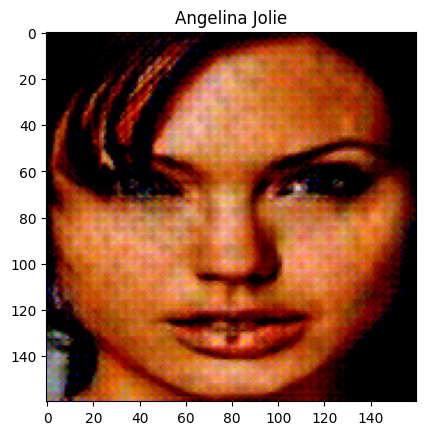

In [ ]:
show_img, show_lbl = dataset[0]
plt.imshow(show_img.permute(1, 2, 0))
plt.title(class_names[show_lbl])
plt.show()

## Preprocess

### Definition

#### Regular

In [ ]:
tform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [ ]:
tform_clean = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([224,224]),
    transforms.ToTensor()
])

## Model Architecture

### Config

In [ ]:
class Config:
  epoch = 30
  batch_size = 64
  num_workers = 0
  lr = [1e-6, 1e-4, 1e-2]
  lr_step = 30
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  patience = 3
  test_model = ""

### Model


#### Model Architecture

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(512, len(class_names), bias=True)
)

#### Loss function

In [ ]:
criterion = nn.CrossEntropyLoss()

#### Checkpoints


In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/11trWVXLBqsIt0M-wbrJypVCXC7J70fan/view?usp=drive_link -O atk_final.pth #Origin ResNet18

Downloading...
From: https://drive.google.com/uc?id=11trWVXLBqsIt0M-wbrJypVCXC7J70fan
To: /content/drive/MyDrive/資安/atk_final.pth
100% 134M/134M [00:00<00:00, 182MB/s]


In [ ]:
def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)

#### Load model

In [ ]:
try:
  best_weight_dir = './atk_final.pth'
  checkpoint = torch.load(best_weight_dir, map_location=Config.device)
  model.load_state_dict(checkpoint['model_state_dict'])
  last_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  Config.test_model = best_weight_dir
  print(f"Load best weight path:{best_weight_dir}, epoch:{last_epoch} / {Config.epoch}, loss:{loss}")
except Exception as e:
  print(e)

Load best weight path:./atk_final.pth, epoch:9 / 30, loss:0.18673479557037354


## Testing

In [ ]:
test_ds_origin = myDataset(image_list, label_list, tform_clean, transforms.Lambda(lambda x: torch.tensor(x)))

test_ds = myDataset(image_list, label_list, tform, transforms.Lambda(lambda x: torch.tensor(x)))
test_dataLoader = DataLoader(test_ds, shuffle=True)

### Top1

In [ ]:
correct_count = 0
model.eval()
model.to(Config.device)

with tqdm(test_dataLoader, total=len(test_dataLoader)) as progress_bar:
  for data, labels in progress_bar:
    data = data.to(Config.device)
    labels = labels.to(Config.device)
    outputs = model(data)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)
    correct_count += torch.sum(preds == labels.data)

print("\nCurrent dataset: " + selections[sect_idx][sel_idx])
print(f"Loss: {loss}, acc: {correct_count.double() / (len(test_dataLoader))}")

100%|██████████| 170/170 [00:52<00:00,  3.25it/s]


Current dataset: FGSM_8_Blur45
Loss: 0.0, acc: 0.25882352941176473


###Top3

In [ ]:
correct_count = 0
model.eval()
model.to(Config.device)

with tqdm(test_dataLoader, total=len(test_dataLoader)) as progress_bar:
  for data, labels in progress_bar:
    data = data.to(Config.device)
    labels = labels.to(Config.device)
    outputs = model(data)
    loss = criterion(outputs, labels)

    _, preds = torch.topk(outputs, 3)
    correct_count += torch.sum(preds == labels)

print("\nCurrent dataset: " + selections[sect_idx][sel_idx])
print(f"Loss: {loss}, acc: {correct_count.double() / (len(test_dataLoader))}")

100%|██████████| 170/170 [00:16<00:00, 10.41it/s]


Current dataset: FGSM_8_Blur45
Loss: 0.4711983799934387, acc: 0.6764705882352942


### Show

Current dataset: FGSM_8_Blur45


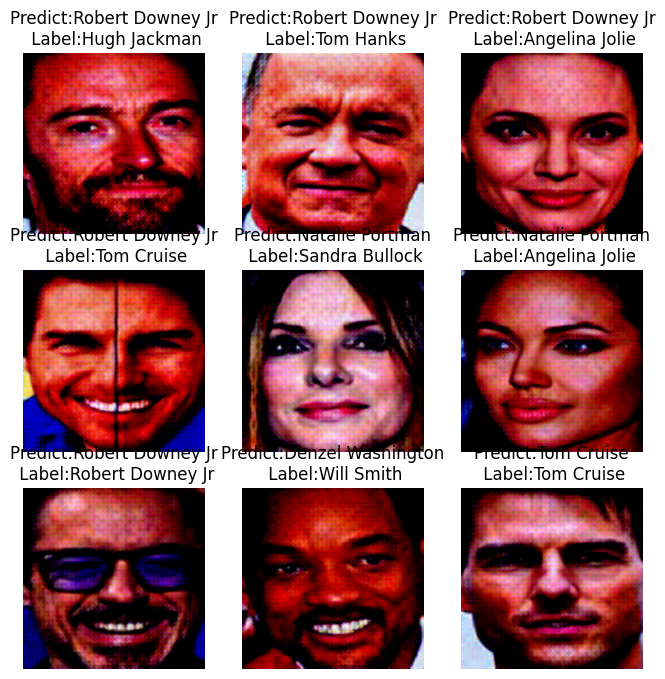

In [ ]:
w = 40
h = 40

columns = 3
rows = 3

fig = plt.figure(figsize=(8, 8))
ax = []

for i in range(1, columns*rows +1):
  idx = random.randint(0, len(test_ds)-1)

  show_img, show_lbl = test_ds[idx]
  show_img, show_lbl = show_img.to(Config.device), show_lbl.to(Config.device)

  x = show_img
  x = x.unsqueeze(0)

  model.eval()
  model = model.to(Config.device)

  with torch.no_grad():
      out = model(x)

  show_img, show_lbl, out = show_img.cpu(), show_lbl.cpu(), out.cpu()
  ax.append(fig.add_subplot(rows, columns, i))
  plt.axis('off')
  #plt.imshow(show_img.permute(1, 2, 0))
  origin_img_show, _ = test_ds_origin[idx]
  plt.imshow(origin_img_show.permute(1, 2, 0))
  plt.title(f"Predict:{class_names[np.argmax(out)]}\n Label:{class_names[show_lbl]}")

print("Current dataset: " + selections[sect_idx][sel_idx])
plt.show()

## Photo Difference

In [ ]:
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity

In [ ]:
def PSNR(MSE):
  PSNR = 10 * np.log10((255 * 255) / MSE)
  return PSNR

In [ ]:
target_name = 'Angelina Jolie_9'
#target_name = 'Angelina_Jolie_72'

target_path = [x for x in image_path_list if os.path.basename(x).startswith(target_name)][0]

origin_path = os.path.join('Origin', 'Angelina Jolie', 'Angelina Jolie_9.png')
#origin_path = os.path.join('Test', 'Angelina Jolie', 'Angelina Jolie_9.png')
comparision_path = os.path.join(target_path)

origin_img = cv2.imread(origin_path)
comparision_img = cv2.imread(comparision_path)

In [ ]:
m1 = mean_squared_error(origin_img, comparision_img)
p1 = PSNR(m1)
s1 = structural_similarity(origin_img, comparision_img, channel_axis=-1)

w = 10
h = 10

columns = 2
rows = 1

fig = plt.figure(figsize=(8, 8))
ax = []
show_list = [origin_img, comparision_img]

for i in range(1, columns*rows +1):
  test = show_list[i - 1]
  ax.append(fig.add_subplot(rows, columns, i))
  plt.axis('off')
  plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
plt.show()

print("Current dataset: " + selections[sect_idx][sel_idx])
print('MSE: {:.3f}, PSNR: {:.3f} SSIM: {:.3f}'.format(m1, p1, s1))

ValueError: ignored

In [ ]:
origin_img = cv2.imread(origin_path)
comparision_img = cv2.imread(comparision_path)

diff_img = comparision_img - origin_img

plt.imshow(cv2.cvtColor(diff_img, cv2.COLOR_BGR2RGB))
plt.show()

print("Current dataset: " + selections[sect_idx][sel_idx])